# This notebook builds a machine learning model to identify the best comparable properties (comps) for real estate valuation
# =============================================================================

In [132]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install openpyxl
# pip install shap openai


## STEP 1: DATA LOADING AND INITIAL EXPLORATION

In [133]:
print("=" * 80)
print("STEP 1: Loading Data")
print("=" * 80)

# Load the datasets
comps_df = pd.read_csv('data/model_ready/comps_pairs_model_ready.csv')
candidates_df = pd.read_csv('data/model_ready/candidates_pair_model_ready.csv')
subjects_df = pd.read_csv('data/cleaned/subjects_cleaned.csv')

# Display basic information
print(f"\n📊 Dataset Sizes:")
print(f"   • Comparable Properties (Positive Class): {len(comps_df):,}")
print(f"   • Candidate Properties (Negative Class): {len(candidates_df):,}")
print(f"   • Subject Properties: {len(subjects_df):,}")
print(f"   • Class Imbalance Ratio: 1:{len(candidates_df)/len(comps_df):.1f}")

STEP 1: Loading Data

📊 Dataset Sizes:
   • Comparable Properties (Positive Class): 264
   • Candidate Properties (Negative Class): 9,820
   • Subject Properties: 88
   • Class Imbalance Ratio: 1:37.2


## STEP 2: FEATURE ENGINEERING AND SELECTION

In [134]:
print("\n" + "=" * 80)
print("STEP 2: Feature Engineering")
print("=" * 80)

# Define feature categories
numerical_features = [
    'gla_diff',           # Gross Living Area difference
    'lot_size_diff',      # Lot size difference
    'bedroom_diff',       # Bedroom count difference
    'bathroom_diff',      # Bathroom count difference
    'room_count_diff'     # Total room count difference
]

categorical_features = [
    'same_property_type', # Same property type (1/0)
    'same_storey_type',   # Same storey type (1/0)
    'sold_recently_90',   # Sold within 90 days (1/0)
    'sold_recently_180'   # Sold within 180 days (1/0)
]

# Additional engineered features
def create_additional_features(df):
    """Create additional features to improve model performance"""
    df = df.copy()
    
    # Percentage differences (handles different scales better)
    df['gla_diff_pct'] = df['gla_diff'] / (df['gla_clean'] + 1) * 100
    df['lot_size_diff_pct'] = df['lot_size_diff'] / (df['lot_size_clean'] + 1) * 100
    
    # Combined similarity score
    df['property_match_score'] = (
        df['same_property_type'] * 0.4 + 
        df['same_storey_type'] * 0.3 + 
        df['sold_recently_90'] * 0.3
    )
    
    # Size similarity (inverse of difference)
    df['size_similarity'] = 1 / (1 + df['gla_diff'].abs() / 100)
    
    return df

# Apply feature engineering
comps_df = create_additional_features(comps_df)
candidates_df = create_additional_features(candidates_df)

# Update feature list
engineered_features = [
    'gla_diff_pct',
    'lot_size_diff_pct',
    'property_match_score',
    'size_similarity'
]

all_features = numerical_features + categorical_features + engineered_features

print(f"\n📊 Total Features: {len(all_features)}")
for i, feature in enumerate(all_features, 1):
    print(f"   {i}. {feature}")


STEP 2: Feature Engineering

📊 Total Features: 13
   1. gla_diff
   2. lot_size_diff
   3. bedroom_diff
   4. bathroom_diff
   5. room_count_diff
   6. same_property_type
   7. same_storey_type
   8. sold_recently_90
   9. sold_recently_180
   10. gla_diff_pct
   11. lot_size_diff_pct
   12. property_match_score
   13. size_similarity


## STEP 3: DATA PREPARATION

In [135]:
print("\n" + "=" * 80)
print("STEP 3: Data Preparation")
print("=" * 80)

# Add labels
comps_df['is_good_comp'] = 1
candidates_df['is_good_comp'] = 0

# Combine datasets
combined_df = pd.concat([comps_df, candidates_df], ignore_index=True)
print(f"\n✅ Combined dataset size: {len(combined_df):,}")

# Handle missing values
print("\n🔧 Handling missing values...")
for col in numerical_features + engineered_features:
    missing_count = combined_df[col].isna().sum()
    if missing_count > 0:
        # Use median for numerical features
        combined_df[col].fillna(combined_df[col].median(), inplace=True)
        print(f"   • {col}: filled {missing_count} missing values with median")

for col in categorical_features:
    missing_count = combined_df[col].isna().sum()
    if missing_count > 0:
        # Use mode for categorical features
        combined_df[col].fillna(0, inplace=True)
        print(f"   • {col}: filled {missing_count} missing values with 0")


STEP 3: Data Preparation

✅ Combined dataset size: 10,084

🔧 Handling missing values...
   • gla_diff: filled 176 missing values with median
   • lot_size_diff: filled 5824 missing values with median
   • bedroom_diff: filled 208 missing values with median
   • bathroom_diff: filled 35 missing values with median
   • room_count_diff: filled 172 missing values with median
   • gla_diff_pct: filled 176 missing values with median
   • lot_size_diff_pct: filled 5824 missing values with median
   • property_match_score: filled 3414 missing values with median
   • size_similarity: filled 176 missing values with median
   • same_property_type: filled 55 missing values with 0
   • same_storey_type: filled 3367 missing values with 0


## STEP 4: TRAIN-TEST SPLIT WITH STRATIFICATION

In [136]:
print("\n" + "=" * 80)
print("STEP 4: Train-Test Split")
print("=" * 80)

# Prepare features and labels
X = combined_df[all_features]
y = combined_df['is_good_comp']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Split Results:")
print(f"   • Training set: {len(X_train):,} samples")
print(f"   • Test set: {len(X_test):,} samples")
print(f"   • Positive class ratio in train: {y_train.mean():.2%}")
print(f"   • Positive class ratio in test: {y_test.mean():.2%}")


STEP 4: Train-Test Split

📊 Split Results:
   • Training set: 8,067 samples
   • Test set: 2,017 samples
   • Positive class ratio in train: 2.62%
   • Positive class ratio in test: 2.63%


## STEP 5: FEATURE SCALING (OPTIONAL BUT RECOMMENDED)

In [137]:
print("\n" + "=" * 80)
print("STEP 5: Feature Scaling")
print("=" * 80)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = numerical_features + engineered_features

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("✅ Numerical features scaled using StandardScaler")


STEP 5: Feature Scaling
✅ Numerical features scaled using StandardScaler


## STEP 6: ADVANCED HYPERPARAMETER TUNING

In [138]:
print("\n" + "=" * 80)
print("STEP 6: Hyperparameter Tuning")
print("=" * 80)

# Calculate scale_pos_weight for imbalanced classes
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\n⚖️  Class weight adjustment: {scale_pos_weight:.2f}")

# Define comprehensive parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500, 800, 1000],  # Go up to 1000
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
    'learning_rate': [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3],  # Try even lower and higher
    'min_child_weight': [1, 2, 3, 5, 7, 10],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.05, 0.1, 0.3, 0.5, 1.0, 2.0],
    'reg_lambda': [0.5, 1.0, 1.2, 1.5, 2.0, 3.0]
}

# Create base model
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc',
    use_label_encoder=False
)

# Perform randomized search with cross-validation
print("\n🔍 Performing randomized search (this may take a few minutes)...")
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train_scaled, y_train)

print(f"\n✅ Best parameters found:")
for param, value in random_search.best_params_.items():
    print(f"   • {param}: {value}")
print(f"\n📊 Best cross-validation score: {random_search.best_score_:.4f}")

# Get the best model
best_model = random_search.best_estimator_


STEP 6: Hyperparameter Tuning

⚖️  Class weight adjustment: 37.23

🔍 Performing randomized search (this may take a few minutes)...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/raahim/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [03:23:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/raahim/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [03:23:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/raahim/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [03:23:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/raahim/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [03:23:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sms


✅ Best parameters found:
   • subsample: 0.8
   • reg_lambda: 0.5
   • reg_alpha: 0.05
   • n_estimators: 300
   • min_child_weight: 7
   • max_depth: 12
   • learning_rate: 0.03
   • gamma: 0.05
   • colsample_bytree: 1.0

📊 Best cross-validation score: 0.9694


## STEP 7: MODEL EVALUATIONS

In [139]:
print("\n" + "=" * 80)
print("STEP 7: Model Evaluation")
print("=" * 80)

# Make predictions
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n📊 ROC-AUC Score: {roc_auc:.4f}")

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

# Find optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\n🎯 Optimal Threshold: {optimal_threshold:.3f}")



STEP 7: Model Evaluation

📊 ROC-AUC Score: 0.9699

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1964
           1       0.51      0.70      0.59        53

    accuracy                           0.97      2017
   macro avg       0.75      0.84      0.79      2017
weighted avg       0.98      0.97      0.98      2017


🎯 Optimal Threshold: 0.026


## STEP 8: FEATURE IMPORTANCE ANALYSIS

In [140]:
print("\n" + "=" * 80)
print("STEP 8: Feature Importance")
print("=" * 80)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 10 Most Important Features:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']}: {row['importance']:.3f}")


STEP 8: Feature Importance

📊 Top 10 Most Important Features:
   same_property_type: 0.753
   sold_recently_180: 0.053
   bathroom_diff: 0.048
   room_count_diff: 0.025
   sold_recently_90: 0.017
   same_storey_type: 0.017
   property_match_score: 0.015
   lot_size_diff_pct: 0.014
   bedroom_diff: 0.013
   gla_diff_pct: 0.013


## STEP 9: PREDICTIONS ON ALL CANDIDATES

In [141]:
print("\n" + "=" * 80)
print("STEP 9: Making Predictions")
print("=" * 80)

# Prepare candidates data
X_candidates = candidates_df[all_features].copy()

# Handle missing values
for col in numerical_features + engineered_features:
    X_candidates[col].fillna(X_candidates[col].median(), inplace=True)
for col in categorical_features:
    X_candidates[col].fillna(0, inplace=True)

# Scale features
X_candidates_scaled = X_candidates.copy()
X_candidates_scaled[numerical_cols] = scaler.transform(X_candidates[numerical_cols])

# Make predictions
candidates_df['comp_probability'] = best_model.predict_proba(X_candidates_scaled)[:, 1]
candidates_df['comp_rank'] = candidates_df.groupby('orderID')['comp_probability'].rank(
    ascending=False, method='first'
)

print(f"\n✅ Predictions made for {len(candidates_df):,} candidates")
print(f"📊 Probability range: [{candidates_df['comp_probability'].min():.3f}, "
      f"{candidates_df['comp_probability'].max():.3f}]")


STEP 9: Making Predictions

✅ Predictions made for 9,820 candidates
📊 Probability range: [0.000, 0.987]


## STEP 10: GENERATE TOP 3 RECOMMENDATIONS

In [142]:
print("\n" + "=" * 80)
print("STEP 10: Generating Top 3 Recommendations")
print("=" * 80)

# Get top 3 candidates per subject
top_3_candidates = candidates_df[candidates_df['comp_rank'] <= 3].copy()

# Create comprehensive recommendation report
recommendations = []

for order_id in top_3_candidates['orderID'].unique():
    # Get subject information
    subject = subjects_df[subjects_df['orderID'] == order_id].iloc[0]
    
    # Get top 3 candidates
    candidates = top_3_candidates[top_3_candidates['orderID'] == order_id].sort_values('comp_rank')
    
    for _, candidate in candidates.iterrows():
        rec = {
            # Subject Information
            'Order ID': order_id,
            'Subject Address': subject.get('address_clean', 'N/A'),
            'Subject GLA': subject['gla_clean'],
            'Subject Lot Size': subject['lot_size_clean'],
            'Subject Bedrooms': subject['bedrooms_clean'],
            'Subject Bathrooms': subject['bathrooms_clean'],
            'Subject Property Type': subject['property_type_clean'],
            'Subject Stories': subject['stories_clean'],
            'Effective Date': subject['effective_date_clean'],
            
            # Candidate Information
            'Comp Rank': int(candidate['comp_rank']),
            'Match Score': f"{candidate['comp_probability']:.1%}",
            'Candidate Address': candidate.get('address_clean', 'N/A'),
            'Candidate GLA': candidate['gla_clean'],
            'Candidate Lot Size': candidate['lot_size_clean'],
            'Candidate Bedrooms': candidate['bedrooms_clean'],
            'Candidate Bathrooms': candidate['bathrooms_clean'],
            'Candidate Property Type': candidate['property_type_clean'],
            'Candidate Stories': candidate['stories_clean'],
            'Sale Date': candidate['close_date_clean'],
            
            # Comparison Metrics
            'GLA Difference': f"{candidate['gla_diff']:.0f} ({candidate['gla_diff_pct']:.1f}%)",
            'Lot Size Difference': f"{candidate['lot_size_diff']:.0f} ({candidate['lot_size_diff_pct']:.1f}%)",
            'Bedroom Difference': candidate['bedroom_diff'],
            'Bathroom Difference': candidate['bathroom_diff'],
            'Same Property Type': '1' if candidate['same_property_type'] else '0',
            'Same Storey Type': '1' if candidate['same_storey_type'] else '0',
            'Recent Sale (90 days)': '1' if candidate['sold_recently_90'] else '0',
            'Recent Sale (180 days)': '1' if candidate['sold_recently_180'] else '0',
            
            # Model Decision Factors
            'Property Match Score': f"{candidate['property_match_score']:.2f}",
            'Size Similarity': f"{candidate['size_similarity']:.2f}"
        }
        recommendations.append(rec)

# Convert to DataFrame
recommendations_df = pd.DataFrame(recommendations)

# Save comprehensive results
recommendations_df.to_csv('data/final_recommendations_detailed.csv', index=False)
print(f"\n✅ Generated recommendations for {recommendations_df['Order ID'].nunique()} subjects")
print(f"📄 Detailed recommendations saved to 'final_recommendations_detailed.csv'")


STEP 10: Generating Top 3 Recommendations

✅ Generated recommendations for 88 subjects
📄 Detailed recommendations saved to 'final_recommendations_detailed.csv'


## STEP 11: VISUAL SUMMARY REPORT


STEP 11: Summary Report

📊 Summary Statistics:
   • Total subjects analyzed: 88
   • Average match score across all recommendations: 39.0%
   • Total recommendations generated: 264

📋 Sample Recommendations (First Subject):

   Rank #1 - Match Score: 0.4%
   Subject: N/A
   Candidate: N/A
   Key Differences:
     • GLA: 56 (5.1%)
     • Bedrooms: 0.0
     • Same Property Type: 0
     • Recent Sale: 1

   Rank #2 - Match Score: 0.3%
   Subject: N/A
   Candidate: N/A
   Key Differences:
     • GLA: 706 (40.3%)
     • Bedrooms: 0.0
     • Same Property Type: 1
     • Recent Sale: 1

   Rank #3 - Match Score: 0.3%
   Subject: N/A
   Candidate: N/A
   Key Differences:
     • GLA: 56 (5.1%)
     • Bedrooms: 0.0
     • Same Property Type: 0
     • Recent Sale: 1


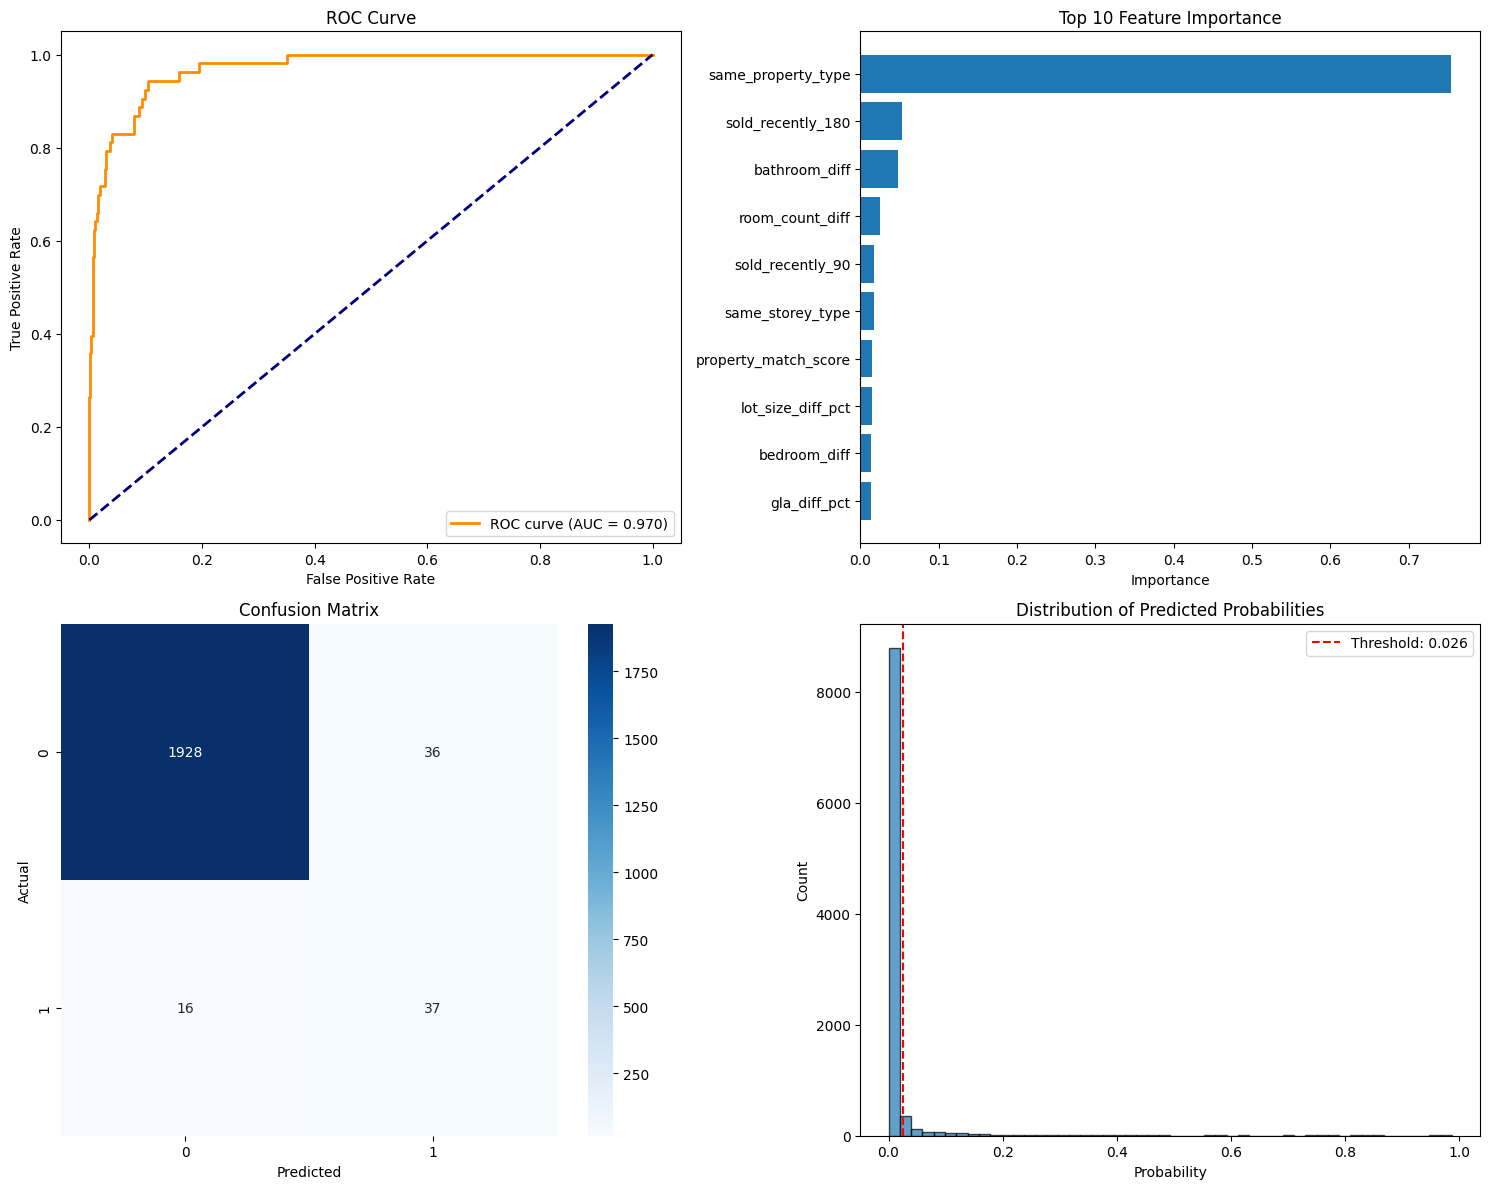


✅ Model training and evaluation complete!
📊 Performance visualizations saved to 'model_performance_summary.png'
💾 Model saved to 'final_xgboost_model.json'


In [143]:
print("\n" + "=" * 80)
print("STEP 11: Summary Report")
print("=" * 80)

# Create summary statistics
summary_stats = recommendations_df.groupby('Order ID').agg({
    'Match Score': lambda x: f"{np.mean([float(s.strip('%'))/100 for s in x]):.1%}",
    'Comp Rank': 'count'
}).rename(columns={'Comp Rank': 'Total Comps'})

print("\n📊 Summary Statistics:")
print(f"   • Total subjects analyzed: {len(summary_stats)}")
print(f"   • Average match score across all recommendations: "
      f"{recommendations_df['Match Score'].apply(lambda x: float(x.strip('%'))/100).mean():.1%}")
print(f"   • Total recommendations generated: {len(recommendations_df)}")

# Display sample recommendations
print("\n📋 Sample Recommendations (First Subject):")
sample = recommendations_df[recommendations_df['Order ID'] == recommendations_df['Order ID'].iloc[0]]
for _, row in sample.iterrows():
    print(f"\n   Rank #{row['Comp Rank']} - Match Score: {row['Match Score']}")
    print(f"   Subject: {row['Subject Address']}")
    print(f"   Candidate: {row['Candidate Address']}")
    print(f"   Key Differences:")
    print(f"     • GLA: {row['GLA Difference']}")
    print(f"     • Bedrooms: {row['Bedroom Difference']}")
    print(f"     • Same Property Type: {row['Same Property Type']}")
    print(f"     • Recent Sale: {row['Recent Sale (90 days)']}")

# =============================================================================
# VISUALIZATION: Model Performance
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend(loc="lower right")

# 2. Feature Importance
top_features = feature_importance.head(10)
axes[0, 1].barh(top_features['feature'], top_features['importance'])
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('Top 10 Feature Importance')
axes[0, 1].invert_yaxis()

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Confusion Matrix')

# 4. Probability Distribution
axes[1, 1].hist(candidates_df['comp_probability'], bins=50, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(optimal_threshold, color='red', linestyle='--', label=f'Threshold: {optimal_threshold:.3f}')
axes[1, 1].set_xlabel('Probability')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Distribution of Predicted Probabilities')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('model_performance_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Model training and evaluation complete!")
print("📊 Performance visualizations saved to 'model_performance_summary.png'")

# Save the trained model
best_model.save_model('data/final_xgboost_model.json')
print("💾 Model saved to 'final_xgboost_model.json'")

## Step 3: Save Best Model Parameters


In [144]:
# Save best parameters for future use
best_params_df = pd.DataFrame([final_model.get_params()])
best_params_df.to_csv('model/best_xgboost_params.csv', index=False)
print("\nBest parameters saved to 'best_xgboost_params.csv'")

# Save the model itself
final_model.save_model('model/best_xgboost_model.json')
print("Model saved to 'best_xgboost_model.json'")


Best parameters saved to 'best_xgboost_params.csv'
Model saved to 'best_xgboost_model.json'


## Step 4: Make Predictions on All Candidates


In [145]:
# Load candidates data if not already loaded
# candidates_df = pd.read_csv('data/model_ready/candidates_pair_model_ready.csv')

# Prepare features
X_candidates = candidates_df[feature_cols].copy()

# Handle missing values (same as training)
for col in ['gla_diff', 'lot_size_diff', 'bedroom_diff', 'bathroom_diff', 'room_count_diff']:
    X_candidates[col] = X_candidates[col].fillna(X_candidates[col].median())

for col in ['same_property_type', 'same_storey_type', 'sold_recently_90']:
    X_candidates[col] = X_candidates[col].fillna(0)

# Get probabilities using the best model
probabilities = final_model.predict_proba(X_candidates)[:, 1]

# Add to candidates dataframe
candidates_df['comp_probability'] = probabilities
candidates_df['comp_rank'] = candidates_df.groupby('orderID')['comp_probability'].rank(
    ascending=False, method='first'
)

print(f"Predictions made for {len(candidates_df)} candidates")
print(f"Probability range: {probabilities.min():.3f} to {probabilities.max():.3f}")

Predictions made for 9820 candidates
Probability range: 0.000 to 0.991


## Step 5: Get Top 3 Candidates per Subject


In [146]:
# Get top 3 candidates for each subject
top_3_per_subject = candidates_df[candidates_df['comp_rank'] <= 3].copy()

# Sort by orderID and rank
top_3_per_subject = top_3_per_subject.sort_values(['orderID', 'comp_rank'])

# Select important columns for the output
output_columns = [
    'orderID',
    'comp_rank',
    'comp_probability',
    # Original property details
    'gla_clean',
    'lot_size_clean',
    'bedrooms_clean', 
    'bathrooms_clean',
    'room_count_clean',
    'property_type_clean',
    'stories_clean',
    'close_date_clean',
    # Differences from subject
    'gla_diff',
    'lot_size_diff',
    'bedroom_diff',
    'bathroom_diff',
    'room_count_diff',
    'same_property_type',
    'same_storey_type',
    'sold_recently_90',
    'sold_recently_180'
]

# Make sure all columns exist
available_columns = [col for col in output_columns if col in top_3_per_subject.columns]
top_3_output = top_3_per_subject[available_columns].copy()

# Rename columns for clarity
top_3_output = top_3_output.rename(columns={
    'comp_rank': 'rank',
    'comp_probability': 'probability_score',
    'gla_clean': 'candidate_gla',
    'lot_size_clean': 'candidate_lot_size',
    'bedrooms_clean': 'candidate_bedrooms',
    'bathrooms_clean': 'candidate_bathrooms',
    'room_count_clean': 'candidate_rooms',
    'property_type_clean': 'candidate_property_type',
    'stories_clean': 'candidate_stories',
    'close_date_clean': 'candidate_sale_date'
})

# Round numerical values for readability
numerical_cols = ['probability_score', 'gla_diff', 'lot_size_diff', 
                  'bedroom_diff', 'bathroom_diff', 'room_count_diff']
for col in numerical_cols:
    if col in top_3_output.columns:
        top_3_output[col] = top_3_output[col].round(3)

print(f"\nTop 3 candidates selected for {top_3_output['orderID'].nunique()} subjects")
print("\nSample of top candidates:")
print(top_3_output.head(6))


Top 3 candidates selected for 88 subjects

Sample of top candidates:
      orderID  rank  probability_score  candidate_gla  candidate_lot_size  \
9800  4723364 1.000              0.476       1300.000            3636.000   
9787  4723364 2.000              0.261       3227.000                 NaN   
9803  4723364 3.000              0.188       1210.000             101.000   
1910  4742669 1.000              0.940        839.000            5392.000   
1945  4742669 2.000              0.530       1078.000            4994.000   
1909  4742669 3.000              0.437        850.000            5995.000   

      candidate_bedrooms  candidate_bathrooms  candidate_rooms  \
9800               3.000                2.000            8.000   
9787               5.000                3.500           17.000   
9803               2.000                2.000            8.000   
1910               3.000                2.000            5.000   
1945               5.000                2.000              N

## Step 6: Create a More Detailed Summary


In [147]:
# Create a summary with subject information included
# First, load subject data
subjects_df = pd.read_csv('data/cleaned/subjects_cleaned.csv')

# Create a comprehensive output
top_3_detailed = []

for order_id in top_3_output['orderID'].unique():
    # Get subject info
    subject = subjects_df[subjects_df['orderID'] == order_id].iloc[0]
    
    # Get top 3 candidates for this subject
    candidates = top_3_output[top_3_output['orderID'] == order_id]
    
    for _, candidate in candidates.iterrows():
        row = {
            # Subject information
            'orderID': order_id,
            'subject_gla': subject['gla_clean'],
            'subject_lot_size': subject['lot_size_clean'],
            'subject_bedrooms': subject['bedrooms_clean'],
            'subject_bathrooms': subject['bathrooms_clean'],
            'subject_property_type': subject['property_type_clean'],
            'subject_stories': subject['stories_clean'],
            'subject_effective_date': subject['effective_date_clean'],
            
            # Candidate information
            'rank': int(candidate['rank']),
            'probability_score': candidate['probability_score'],
            'candidate_gla': candidate['candidate_gla'],
            'candidate_lot_size': candidate['candidate_lot_size'],
            'candidate_bedrooms': candidate['candidate_bedrooms'],
            'candidate_bathrooms': candidate['candidate_bathrooms'],
            'candidate_property_type': candidate['candidate_property_type'],
            'candidate_stories': candidate['candidate_stories'],
            'candidate_sale_date': candidate['candidate_sale_date'],
            
            # Comparison metrics
            'gla_difference': candidate['gla_diff'],
            'lot_size_difference': candidate['lot_size_diff'],
            'bedroom_difference': candidate['bedroom_diff'],
            'bathroom_difference': candidate['bathroom_diff'],
            'is_same_property_type': candidate['same_property_type'],
            'is_same_storey_type': candidate['same_storey_type'],
            'sold_within_90_days': candidate['sold_recently_90'],
            'sold_within_180_days': candidate['sold_recently_180']
        }
        top_3_detailed.append(row)

# Convert to DataFrame
top_3_detailed_df = pd.DataFrame(top_3_detailed)

print(f"\nDetailed summary created with {len(top_3_detailed_df)} rows")
print(f"Covering {top_3_detailed_df['orderID'].nunique()} subjects")


Detailed summary created with 264 rows
Covering 88 subjects


## Step 7: Save Results with Summary Statistics


In [148]:
# Save detailed results
top_3_detailed_df.to_csv('top_3_comparables_per_subject.csv', index=False)
print("\nDetailed results saved to 'top_3_comparables_per_subject.csv'")

# Create a summary statistics file
summary_stats = []

for order_id in top_3_detailed_df['orderID'].unique():
    subject_candidates = top_3_detailed_df[top_3_detailed_df['orderID'] == order_id]
    
    stats = {
        'orderID': order_id,
        'avg_probability_top3': subject_candidates['probability_score'].mean(),
        'max_probability': subject_candidates['probability_score'].max(),
        'min_probability': subject_candidates['probability_score'].min(),
        'avg_gla_diff': subject_candidates['gla_difference'].mean(),
        'avg_bedroom_diff': subject_candidates['bedroom_difference'].mean(),
        'pct_same_property_type': subject_candidates['is_same_property_type'].mean() * 100,
        'pct_sold_within_90_days': subject_candidates['sold_within_90_days'].mean() * 100
    }
    summary_stats.append(stats)

summary_stats_df = pd.DataFrame(summary_stats)
summary_stats_df = summary_stats_df.round(3)

# Save summary
summary_stats_df.to_csv('data/top_3_summary_statistics.csv', index=False)
print("Summary statistics saved to 'top_3_summary_statistics.csv'")

# Display summary
print("\nSummary Statistics (first 10 subjects):")
print(summary_stats_df.head(10))


Detailed results saved to 'top_3_comparables_per_subject.csv'
Summary statistics saved to 'top_3_summary_statistics.csv'

Summary Statistics (first 10 subjects):
   orderID  avg_probability_top3  max_probability  min_probability  \
0  4723364                 0.308            0.476            0.188   
1  4742669                 0.636            0.940            0.437   
2  4752865                 0.254            0.337            0.204   
3  4755196                 0.722            0.785            0.679   
4  4756192                 0.006            0.011            0.004   
5  4756320                 0.911            0.955            0.855   
6  4756829                 0.303            0.533            0.062   
7  4757939                 0.690            0.810            0.578   
8  4757966                 0.004            0.004            0.003   
9  4758025                 0.314            0.351            0.281   

   avg_gla_diff  avg_bedroom_diff  pct_same_property_type  \
0    